In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Pre-process Data

In [ ]:
import numpy as np
from skimage.util.shape import view_as_windows
from PIL import Image
from matplotlib import pyplot as plt


def preprocess_data():
  train = []
  traing = []
  test=[]
  testg=[]
  for i in range(1,401):
    imgName=''
    if i<100:
      if i<10:
        imgName='00'+str(i)
      else:
        imgName='0'+str(i)
    else:
      imgName=str(i)
    # varun path - /content/drive/MyDrive/SMAI/Project/train400/test_
    file = "/content/drive/MyDrive/Colab Notebooks/SMAI /Project/train400/test_"+imgName+".png"
    image = Image.open(file)
    image = np.asarray(image)  
    train.append(image)

  for i in range(1,8):
    # imgName=''
    # if i<100:
    #   if i<10:
    #     imgName='00'+str(i)
    #   else:
    #     imgName='0'+str(i)
    # else:
    imgName=str(i)
    # varun path - /content/drive/MyDrive/SMAI/Project/train400/test_
    file = "/content/drive/MyDrive/Colab Notebooks/SMAI /Project/set12/0"+imgName+".png"
    image = Image.open(file)
    image = np.asarray(image)  
    test.append(image)

  train =  np.array(train).reshape((-1,180,180))
  test =  np.array(test).reshape((-1,256,256))

  mean = 0
  sigma = 50

  gauss_train = np.random.normal(mean,sigma,(180,180))
  gauss_test = np.random.normal(mean,sigma,(256,256))

  traing = train + gauss_train
  testg = test+gauss_test

  train = train/255.0
  traing = traing/255.0
  test=test/255
  testg=testg/255

  for i in range(4):
    plt.imshow(train[i],cmap='gray')
    plt.show()
    plt.imshow(traing[i],cmap='gray')
    plt.show()
  for i in range(4):
    plt.imshow(test[i],cmap='gray')
    plt.show()
    plt.imshow(testg[i],cmap='gray')
    plt.show()
  
  return train,traing,test,testg

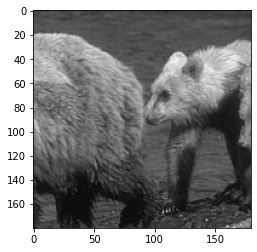

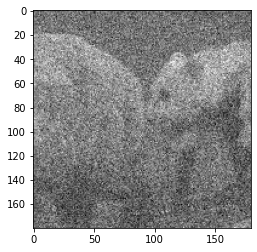

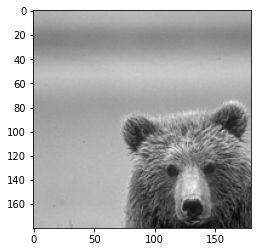

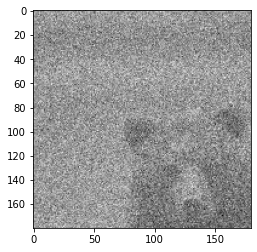

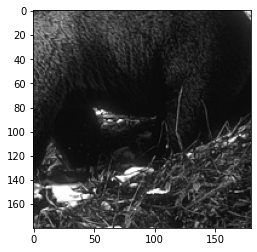

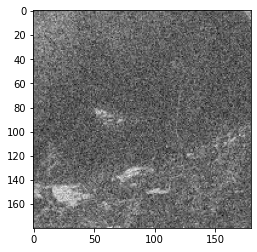

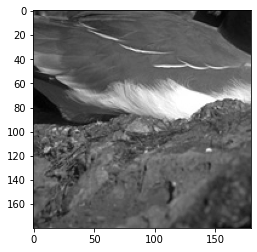

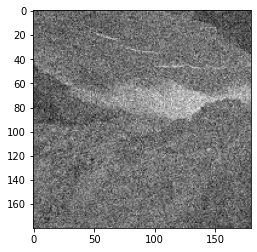

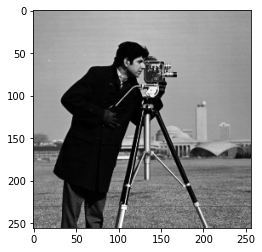

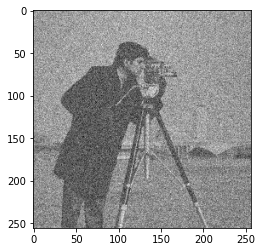

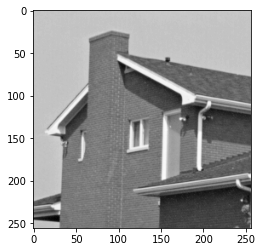

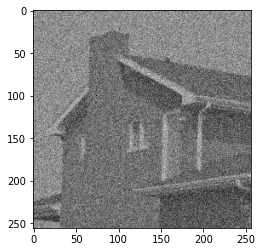

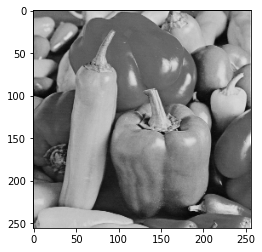

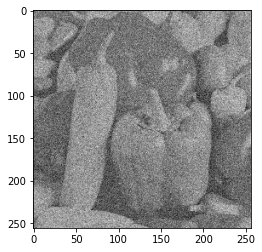

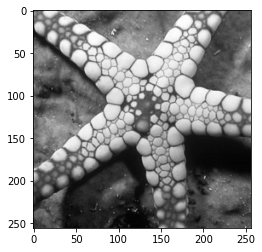

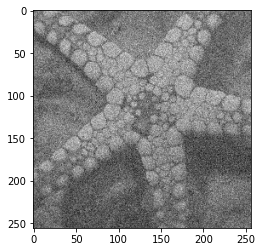

(400, 180, 180, 1) (400, 180, 180, 1) (7, 256, 256, 1) (7, 256, 256, 1)


In [ ]:
# from sklearn.model_selection import train_test_split

# data, datag = preprocess_data()


# traing, testg, train, test =  train_test_split(datag, data, test_size=0.25, shuffle=True)
train,traing,test,testg=preprocess_data()
train = np.expand_dims(train,axis=-1)
traing = np.expand_dims(traing,axis=-1)
test = np.expand_dims(test,axis=-1)
testg = np.expand_dims(testg,axis=-1)
print(train.shape,traing.shape, test.shape, testg.shape)

Define Model

In [ ]:
import tensorflow as tf

In [ ]:
class FeatureExtraction(tf.keras.Model):
  def __init__(self):
    super(FeatureExtraction,self).__init__()
    self.conv_block_up=tf.keras.layers.Conv2D(8,(3,3), padding="same", strides=1, activation="relu")
    self.dilated_conv_block_up=tf.keras.layers.Conv2D(8,(3,3), padding="same", strides=1, dilation_rate=2,activation="relu")

    self.conv_block_down=tf.keras.layers.Conv2D(8,(3,3), padding="same", strides=1, activation="relu")
    self.dilated_conv_block_down=tf.keras.layers.Conv2D(8,(3,3), padding="same", strides=1, dilation_rate=2,activation="relu")

  def call(self,input_tensor):
    x=self.conv_block_up(input_tensor)
    y=self.dilated_conv_block_up(x)
    z=self.dilated_conv_block_down(input_tensor)
    a=self.conv_block_down(z)

    return tf.keras.layers.Add()([x,y,z,a])

In [ ]:
class FeatureIntegration(tf.keras.Model):
  def __init__(self):
    super(FeatureIntegration,self).__init__()
    self.conv_block_first=tf.keras.layers.Conv2D(1,(1,1), strides=1,padding="same", activation="relu")
    self.conv_block_up=tf.keras.layers.Conv2D(8,(3,3), strides=1,padding="same", activation="relu")
    self.dilated_conv_block_up=tf.keras.layers.Conv2D(8,(3,3),dilation_rate=2,padding="same",activation="relu")
    self.conv_block_down=tf.keras.layers.Conv2D(8,(3,3), strides=1,padding="same", activation="relu")
    self.dilated_conv_block_down=tf.keras.layers.Conv2D(8,(3,3),dilation_rate=2,padding="same",activation="relu")
    self.conv_block_second=tf.keras.layers.Conv2D(1,(1,1), strides=1,padding="same", activation="relu")
  def call(self,input_tensor):
    b=self.conv_block_first(input_tensor)
    x=self.conv_block_up(b)
    y=self.dilated_conv_block_up(x)
    z=self.dilated_conv_block_down(b)
    a=self.conv_block_down(z)
    add_first=tf.keras.layers.Add()([x,y,z,a])
    f=self.conv_block_second(add_first)
    return tf.keras.layers.Add()([f,input_tensor])

In [ ]:
class Reconstruction(tf.keras.Model):
  def __init__(self):
    super(Reconstruction,self).__init__()
    self.conv_block_first=tf.keras.layers.Conv2D(1,(1,1), strides=1,padding="same", activation="sigmoid")
  def call(self,input_tensor):
    b=self.conv_block_first(input_tensor)
    return b

Build Model

In [ ]:
from keras.models import Sequential

model = Sequential()

model.add(FeatureExtraction())

model.add(FeatureIntegration())
model.add(FeatureIntegration())
model.add(FeatureIntegration())
model.add(FeatureIntegration())
model.add(FeatureIntegration())
model.add(FeatureIntegration())
model.add(FeatureIntegration())
model.add(FeatureIntegration())

model.add(Reconstruction())

model.compile(loss='mse')


results = model.fit(traing, train, epochs=50, verbose=1)

model.summary()


Epoch 1/50
13/13 [==============================] - 12s 366ms/step - loss: 0.0352
Epoch 2/50
13/13 [==============================] - 4s 337ms/step - loss: 0.0139
Epoch 3/50
13/13 [==============================] - 4s 342ms/step - loss: 0.0111
Epoch 4/50
13/13 [==============================] - 4s 341ms/step - loss: 0.0097
Epoch 5/50
13/13 [==============================] - 4s 342ms/step - loss: 0.0085
Epoch 6/50
13/13 [==============================] - 4s 341ms/step - loss: 0.0080
Epoch 7/50
13/13 [==============================] - 4s 343ms/step - loss: 0.0078
Epoch 8/50
13/13 [==============================] - 4s 342ms/step - loss: 0.0070
Epoch 9/50
13/13 [==============================] - 4s 342ms/step - loss: 0.0070
Epoch 10/50
13/13 [==============================] - 4s 343ms/step - loss: 0.0068
Epoch 11/50
13/13 [==============================] - 4s 344ms/step - loss: 0.0067
Epoch 12/50
13/13 [==============================] - 5s 345ms/step - loss: 0.0066
Epoch 13/50
13/13 [=====

In [ ]:
import pickle
with open('/content/drive/MyDrive/Colab Notebooks/SMAI /Project/model_1.pickle', 'wb') as f:
    pickle.dump(model, f)

# with open('/content/drive/MyDrive/Colab Notebooks/SMAI /Project/model_1.pickle', 'rb') as f:
#     my_df_unpickled = pickle.load(f)

INFO:tensorflow:Assets written to: ram://7b4b529f-822e-4d79-82e9-99b8f10d9f00/assets


In [ ]:
import numpy as np
from math import log2, log10

def _initial_check(GT,P):
	assert GT.shape == P.shape, "Supplied images have different sizes " + \
	str(GT.shape) + " and " + str(P.shape)
	if GT.dtype != P.dtype:
		msg = "Supplied images have different dtypes " + \
			str(GT.dtype) + " and " + str(P.dtype)
		print(msg)
	

	if len(GT.shape) == 2:
		GT = GT[:,:,np.newaxis]
		P = P[:,:,np.newaxis]

	return GT.astype(np.float64),P.astype(np.float64)

def mse (GT,P):
	"""calculates mean squared error (mse).

	:param GT: first (original) input image.
	:param P: second (deformed) input image.

	:returns:  float -- mse value.
	"""
	GT,P = _initial_check(GT,P)
	return np.mean((GT.astype(np.float64)-P.astype(np.float64))**2)

def psnr (GT,P,MAX=None):
	"""calculates peak signal-to-noise ratio (psnr).

	:param GT: first (original) input image.
	:param P: second (deformed) input image.
	:param MAX: maximum value of datarange (if None, MAX is calculated using image dtype).

	:returns:  float -- psnr value in dB.
	"""
	if MAX is None:
		MAX = np.iinfo(GT.dtype).max

	GT,P = _initial_check(GT,P)

	mse_value = mse(GT,P)
	if mse_value == 0.:
		return np.inf
	return 10 * np.log10(MAX**2 /mse_value)

In [ ]:
pred = model(testg)
# print(pred.shape,test.shape)


mseloss = (1/7)*np.mean((pred-test)**2)

# mseloss = np.mean((pred.astype(np.float64)-P.astype(np.float64))**2)
psnr_ =   10*np.log10(1/mseloss)
print("psnr with model",psnr_)

psnr with model 31.92133195054009


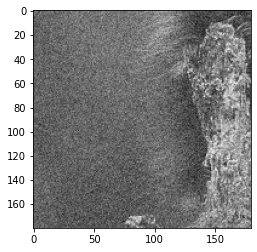

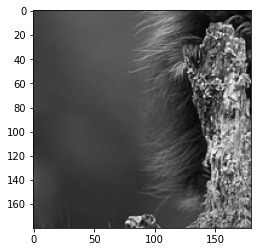

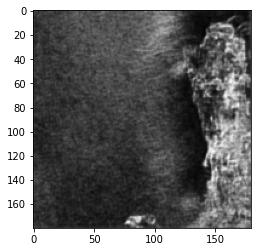

In [ ]:
plt.imshow(np.squeeze(testg[20],(-1)),cmap='gray')
plt.show()

plt.imshow(np.squeeze(test[20],(-1)),cmap='gray')
plt.show()

temp = np.expand_dims(testg[20],axis=0)

pred = model(temp)

pred = np.squeeze(pred,(0,-1))

plt.imshow(pred*256,cmap='gray')
plt.show()

In [ ]:
testg[20],pred

In [ ]:
test[20].shape,pred.shape
pred=y = np.expand_dims(pred,-1)
test[20].shape,pred.shape

((180, 180, 1), (180, 180, 1))

In [ ]:
print("psnr with added gaussian noise",psnr(test[20],testg[20],1))
print("psnr with predicted",psnr(test[20],pred,1))

psnr with added gaussian noise 20.139722697513914
Supplied images have different dtypes float64 and float32
psnr with predicted 24.22030384011249
